https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

and associated github directory https://github.com/1297rohit/RCNN

Note that RCNN.ipynb in github repo seems to have more stuff in it, but follow medium post for now.

*Background material*

https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/

https://stackoverflow.com/questions/57427233/module-cv2-cv2-has-no-attribute-ximgproc

- pip install opencv-contrib-python (if opencv-python is installed, remove it before this step)
- pip install keras
- tensorflow already installed

In [ ]:
import tensorflow as tf
import keras

In [7]:
import os,cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

- Download the files: Images.zip and Airplanes_Annotations.zip
- Extract all images to Images subdirectory one level below this notebook
- Extract all labels to Airplanes_Annotations subdirectory one level below this notebook

In [10]:
path = "Images"
annot ="Airplanes_Annotations"

Test one image

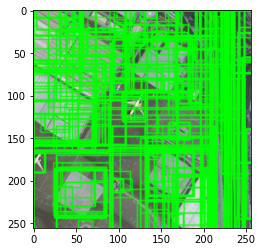

In [34]:
im = cv2.imread(os.path.join(path,"42850.jpg"))
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
imOut = im.copy()
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
#     print(x,y,w,h)
#     imOut = imOut[x:x+w,y:y+h]
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

42845.jpg


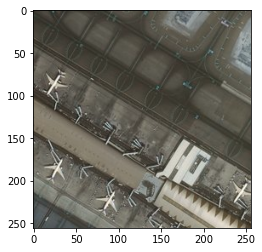

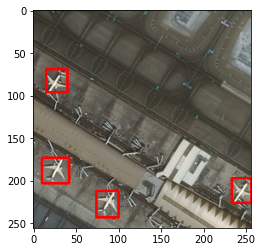

In [11]:
for e,i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path,filename))
        #print(img)
        df = pd.read_csv(os.path.join(annot,i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        break

Initialize selective search

In [17]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

Function to calculate IOU (Intersection Over Union) of the ground truth box from the box computed by selective search.

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [18]:
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

## Preprocessing and dataset creation
Steps for pre-processing and creating the data-set to pass to the model. We can have 2 classes: these classes are that the proposed region can be a foreground (i.e. Airplane) or a background. So we will set the label of foreground (i.e. Airplane) as 1 and the label of background as 0. Steps are:
1. Loop over the image folder and set each image one by one as the base for selective search using code ss.setBaseImage(image)
2. Initialising fast selective search and getting proposed regions using using code ss.switchToSelectiveSearchFast() and ssresults = ss.process()
3. Iterating over all the first 2000 results passed by selective search and calculating IOU of the proposed region and annotated region using the get_iou() function created above.
4. Now as one image can many negative sample (i.e. background) and just some positive sample (i.e. airplane) so we need to make sure that we have good proportion of both positive and negative sample to train our model. Therefore we have set that we will collect maximum of 30 negative sample (i.e. background) and positive sample (i.e. airplane) from one image.

In [19]:
train_images=[]
train_labels=[]

**NOTE** Next cell takes a good 15 min to run!

In [20]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

17 airplane_001.jpg
inside
18 airplane_002.jpg
19 airplane_003.jpg
20 airplane_004.jpg
inside
21 airplane_005.jpg
inside
22 airplane_006.jpg
23 airplane_007.jpg
inside
24 airplane_008.jpg
25 airplane_009.jpg
26 airplane_010.jpg
27 airplane_011.jpg
28 airplane_012.jpg
inside
29 airplane_013.jpg
30 airplane_014.jpg
31 airplane_015.jpg
32 airplane_016.jpg
33 airplane_017.jpg
34 airplane_018.jpg
35 airplane_019.jpg
36 airplane_020.jpg
37 airplane_021.jpg
38 airplane_022.jpg
39 airplane_023.jpg
40 airplane_024.jpg
41 airplane_025.jpg
42 airplane_026.jpg
43 airplane_027.jpg
44 airplane_028.jpg
45 airplane_029.jpg
46 airplane_030.jpg
47 airplane_031.jpg
48 airplane_032.jpg
49 airplane_033.jpg
50 airplane_034.jpg
51 airplane_035.jpg
52 airplane_036.jpg
53 airplane_037.jpg
54 airplane_038.jpg
55 airplane_039.jpg
56 airplane_040.jpg
57 airplane_041.jpg
inside
58 airplane_042.jpg
59 airplane_043.jpg
60 airplane_044.jpg
61 airplane_045.jpg
inside
62 airplane_046.jpg
63 airplane_047.jpg
64 airplane

396 airplane_380.jpg
397 airplane_381.jpg
398 airplane_382.jpg
inside
399 airplane_383.jpg
inside
400 airplane_384.jpg
401 airplane_385.jpg
inside
402 airplane_386.jpg
403 airplane_387.jpg
404 airplane_388.jpg
inside
405 airplane_389.jpg
406 airplane_390.jpg
407 airplane_391.jpg
408 airplane_392.jpg
409 airplane_393.jpg
410 airplane_394.jpg
411 airplane_395.jpg
412 airplane_396.jpg
413 airplane_397.jpg
414 airplane_398.jpg
415 airplane_399.jpg
416 airplane_400.jpg
417 airplane_401.jpg
418 airplane_402.jpg
419 airplane_403.jpg
420 airplane_404.jpg
421 airplane_405.jpg
422 airplane_406.jpg
423 airplane_407.jpg
424 airplane_408.jpg
425 airplane_409.jpg
426 airplane_410.jpg
427 airplane_411.jpg
428 airplane_412.jpg
429 airplane_413.jpg
430 airplane_414.jpg
431 airplane_415.jpg
432 airplane_416.jpg
433 airplane_417.jpg
434 airplane_418.jpg
435 airplane_419.jpg
inside
436 airplane_420.jpg
437 airplane_421.jpg
438 airplane_422.jpg
439 airplane_423.jpg
440 airplane_424.jpg
441 airplane_425.jpg

Training data is now ready. List train_images=[] will contain all the images and train_labels=[] will contain all the labels marking airplane images as 1 and non airplane images (i.e. background images) as 0.

In [23]:
# check for 0,1
print(train_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 

## Train a model
After completing the process of creating the dataset we will convert the array to numpy array so that we can traverse it easily and pass the datatset to the model in an efficient way.

In [24]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

Now we will do transfer learning on the imagenet weight. We will import VGG16 model and also put the imagenet weight in the model. To learn more about transfer learning you can refer to the article on link below.

https://medium.com/@1297rohit/transfer-learning-from-scratch-using-keras-339834b153b9

https://keras.io/api/applications/ For more on keras VGG16 model

In [25]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
vggmodel = VGG16(weights='imagenet', include_top=True)

553467904/553467096 [==============================] - 95s 0us/step


- we are freezing the first 15 layers of the model. 
- After that we are taking out the second last layer of the model and then adding a 2 unit softmax dense layer as we have just 2 classes to predict i.e. foreground or background. 
- After that we are compiling the model using Adam optimizer with learning rate of 0.001. We are using categorical_crossentropy as loss since the output of the model is categorical. 
- Finally the summary of the model will is printed using model_final.summary().

In [27]:
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False
X = vggmodel.layers[-2].output
predictions = Dense(2, activation="softmax")(X)

Error with the keyword input below: https://github.com/keras-team/keras/issues/13743

In [29]:
#model_final = Model(input = vggmodel.input, output = predictions) # error
model_final = Model(vggmodel.input, predictions) # no error using positional keywords
opt = Adam(lr=0.0001)
model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Encode the dataset
After creating the model now we need to split the dataset into train and test set. Before that we need to one-hot encode the label. For that we are using MyLabelBinarizer() and encoding the dataset. Then we are splitting the dataset using train_test_split from sklearn. We are keeping 10% of the dataset as test set and 90% as training set.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [42]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

Use Keras ImageDataGenerator to pass the dataset to the model. We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset.

In [43]:
# Check dtype of train/test data
print(X_train.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_test.dtype)

uint8
uint8
int32
int32


In [45]:
# Converting dtype doesn't help
#y_train = y_train.astype(np.uint8)
#y_test = y_test.astype(np.uint8)
print(y_train.dtype)
print(y_test.dtype)

uint8
uint8


***
Nexy cell gives a **MemoryError: Unable to allocate 15.3 GiB for an array with shape (27206, 224, 224, 3) and data type float32**
Can't go any further with this. I'll copy in the code anyway.

Possible solution:
https://stackoverflow.com/questions/57507832/unable-to-allocate-array-with-shape-and-data-type

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

keras ImageDataGenerator class: https://keras.io/api/preprocessing/image/

Possibly the batch_size in flow? No.

In [51]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)# *
#traindata = trdata.flow(x=X_train, y=y_train, batch_size=4)# batch_size <32 doesn't help
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

MemoryError: Unable to allocate 15.3 GiB for an array with shape (27206, 224, 224, 3) and data type float32

## Couldn't run rest of nb due to memory error above
Now we start the training of the model using fit_generator.

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("ieeercnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Once we have created the model. We need to do prediction on that model. For that we need to follow these steps:
- pass the image from selective search.
- pass all the result of the selective search to the model as input using model_final.predict(img).
- If the output of the model says the region to be a foreground image (i.e. airplane image), and if the confidence is above the defined threshold, then create bounding box on the original image on the coordinate of the proposed region.

In [ ]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.70:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)
        break